**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

**Visualising Data**

  session_id  network_packet_size protocol_type  login_attempts  \
0  SID_00001                  599           TCP               4   
1  SID_00002                  472           TCP               3   
2  SID_00003                  629           TCP               3   
3  SID_00004                  804           UDP               4   
4  SID_00005                  453           TCP               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             DES             0.606818              1   
1       1557.996461             DES             0.301569              0   
2         75.044262             DES             0.739164              2   
3        601.248835             DES             0.123267              0   
4        532.540888             AES             0.054874              1   

  browser_type  unusual_time_access  attack_detected  
0         Edge                    0                1  
1      Firefox                    0 

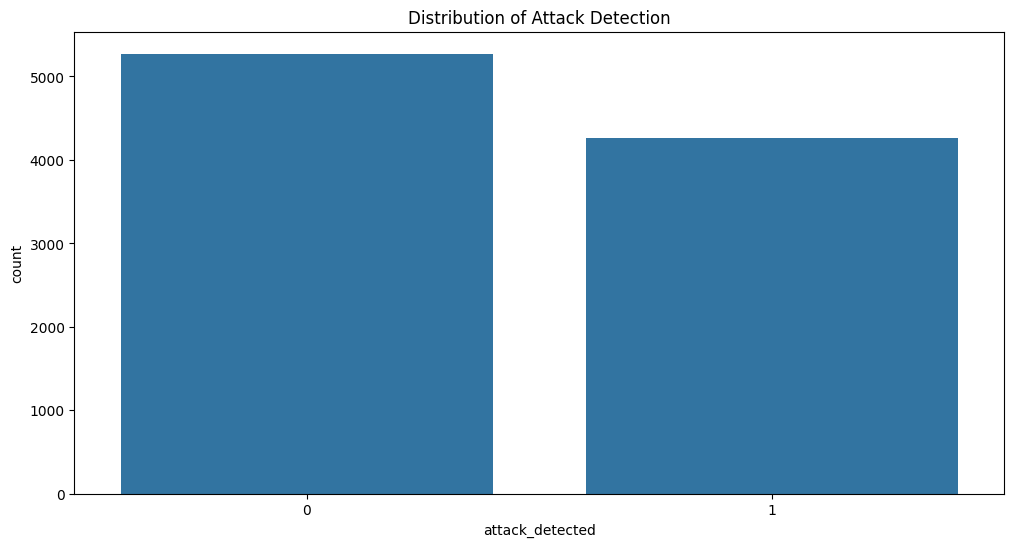

In [4]:
# Load dataset
df = pd.read_csv('/content/cybersecurity_intrusion_data.csv')

# Display first few rows
print(df.head())

# Visualize data
plt.figure(figsize=(12, 6))
sns.countplot(x='attack_detected', data=df)
plt.title('Distribution of Attack Detection')
plt.show()


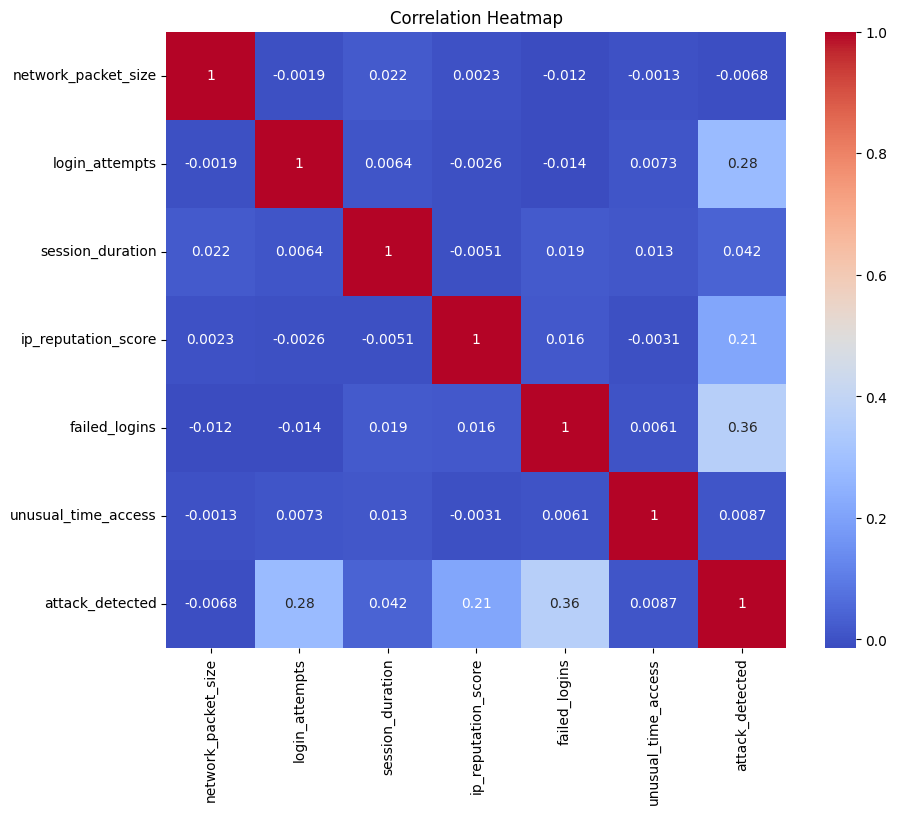

In [5]:
plt.figure(figsize=(10, 8))
numerical_df = df.select_dtypes(include=np.number)  # Select only numerical columns
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Pre-Processing Data**

In [6]:
# Define features and target
y = df['attack_detected']
X = df.drop(columns=['attack_detected'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define numerical and categorical features
numerical_features = ['login_attempts', 'ip_reputation_score', 'failed_logins']
categorical_features = ['protocol_type', 'encryption_used', 'browser_type']

# Define preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

**5 Different Trees**

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
tree_models = {
    'Decision Tree (Gini)': DecisionTreeClassifier(criterion='gini', random_state=42),
    'Decision Tree (Entropy)': DecisionTreeClassifier(criterion='entropy', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for name, model in tree_models.items():
    print(f"\nTraining and Evaluating: {name}")
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} Accuracy Score: {accuracy_score(y_test, y_pred):.4f}\n")


Training and Evaluating: Decision Tree (Gini)

Decision Tree (Gini) Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1079
           1       0.78      0.79      0.78       829

    accuracy                           0.81      1908
   macro avg       0.81      0.81      0.81      1908
weighted avg       0.81      0.81      0.81      1908

Decision Tree (Gini) Accuracy Score: 0.8103


Training and Evaluating: Decision Tree (Entropy)

Decision Tree (Entropy) Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1079
           1       0.77      0.80      0.78       829

    accuracy                           0.81      1908
   macro avg       0.80      0.81      0.80      1908
weighted avg       0.81      0.81      0.81      1908

Decision Tree (Entropy) Accuracy Score: 0.8071


Training and Evaluating: Random Forest

Random Forest Classi

**Applying IREP**

In [10]:
def prune_tree(tree, X_train, y_train, X_prune, y_prune, preprocessor):
    best_tree = tree
    X_prune_transformed = preprocessor.transform(X_prune)
    best_accuracy = accuracy_score(y_prune, best_tree.predict(X_prune_transformed))

    for depth in range(1, tree.get_depth()):
        pruned_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
        X_train_transformed = preprocessor.transform(X_train)
        pruned_tree.fit(X_train_transformed, y_train)
        accuracy = accuracy_score(y_prune, pruned_tree.predict(X_prune_transformed))

        if accuracy >= best_accuracy:
            best_tree = pruned_tree
            best_accuracy = accuracy

    return best_tree

In [12]:
def visualize_tree(tree, feature_names, title="Decision Tree"): # Defining the visualize_tree function
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, filled=True, rounded=True, class_names=True) # Using plot_tree from sklearn.tree
    plt.title(title)
    plt.show()

In [15]:
def IREPPosNeg(tree_model, X_train, y_train, X_test, y_test, preprocessor):
    X_train_main, X_prune, y_train_main, y_prune = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    pruned_tree = prune_tree(tree_model, X_train_main, y_train_main, X_prune, y_prune, preprocessor)

    X_test_transformed = preprocessor.transform(X_test)
    y_pred_pruned = pruned_tree.predict(X_test_transformed)

    print("\nClassification Report (After IREP Pruning):\n", classification_report(y_test, y_pred_pruned))

    rules_after = export_text(pruned_tree, feature_names=preprocessor.get_feature_names_out())
    print("\nExtracted Rules After Pruning:\n", rules_after)

    # Visualize the normal tree
    print("\nVisualizing Normal Tree:")
    visualize_tree(tree_model, preprocessor.get_feature_names_out())

    # Visualize the pruned tree
    print("\nVisualizing Pruned Tree:")
    visualize_tree(pruned_tree, preprocessor.get_feature_names_out())

    return pruned_tree



Classification Report (After IREP Pruning):
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1079
           1       0.78      0.79      0.78       829

    accuracy                           0.81      1908
   macro avg       0.81      0.81      0.81      1908
weighted avg       0.81      0.81      0.81      1908


Extracted Rules After Pruning:
 |--- num__failed_logins <= 0.95
|   |--- num__login_attempts <= 1.23
|   |   |--- num__ip_reputation_score <= 1.52
|   |   |   |--- cat__browser_type_Unknown <= 0.50
|   |   |   |   |--- num__ip_reputation_score <= 1.31
|   |   |   |   |   |--- num__ip_reputation_score <= -1.84
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- num__ip_reputation_score >  -1.84
|   |   |   |   |   |   |--- num__ip_reputation_score <= -1.66
|   |   |   |   |   |   |   |--- num__ip_reputation_score <= -1.78
|   |   |   |   |   |   |   |   |--- num__ip_reputation_score <= -1.78
|   |   |   |   |

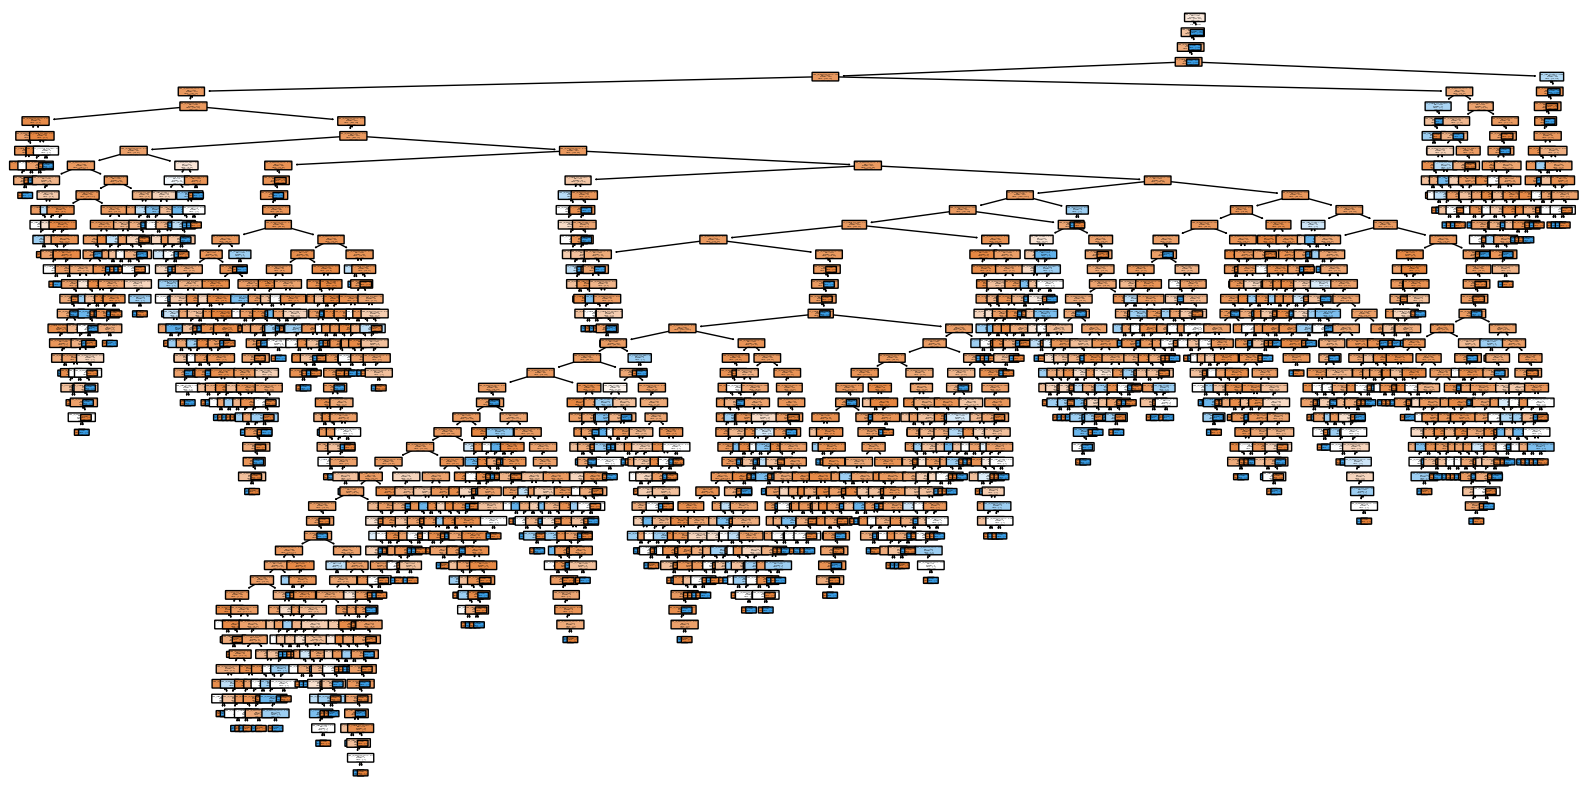


Visualizing Pruned Tree:


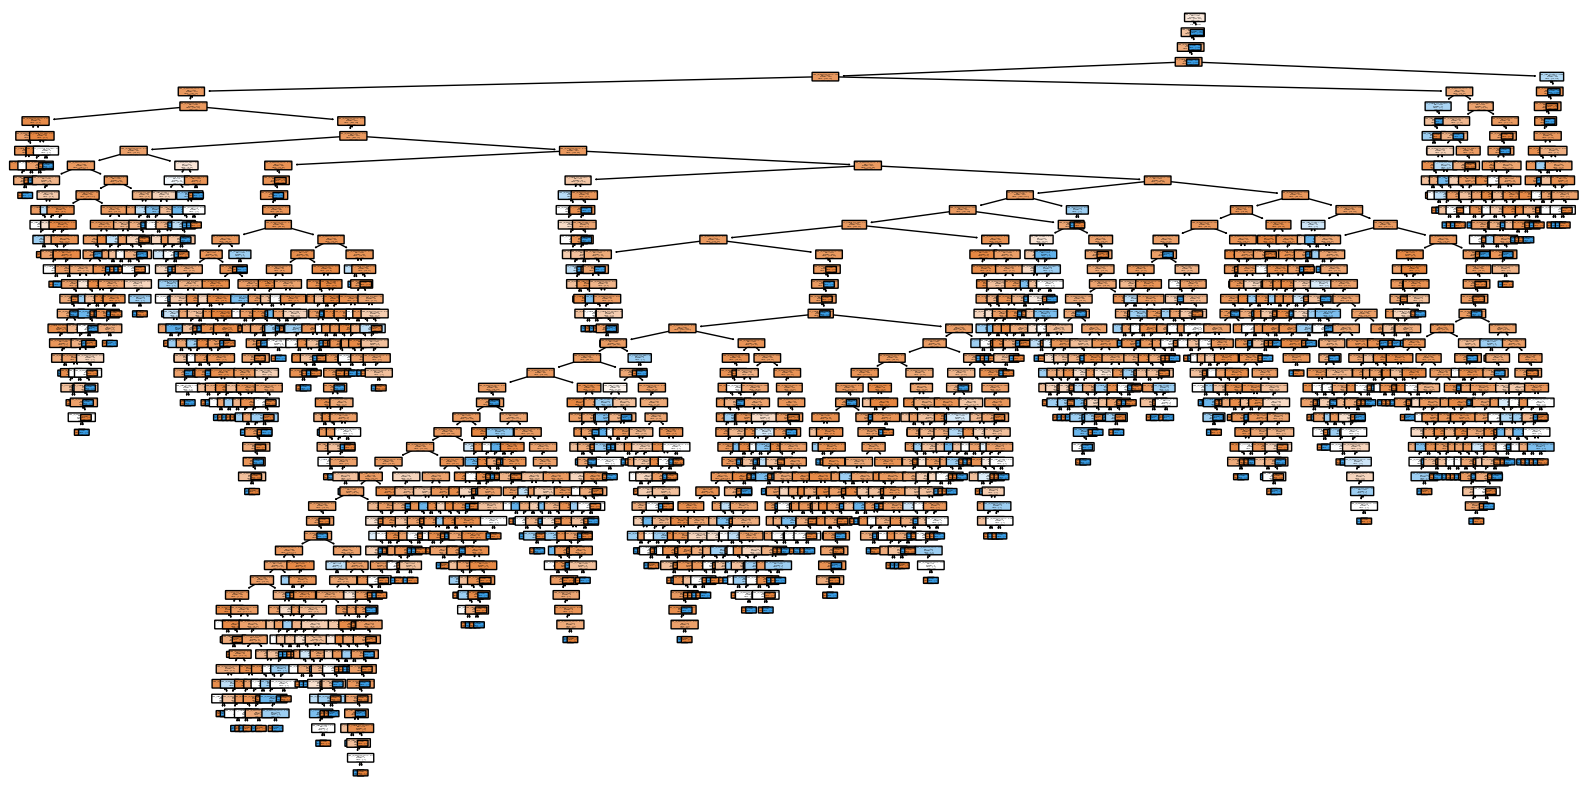

DecisionTreeClassifier(random_state=42)

In [16]:
# Apply IREP to the default decision tree
default_tree = tree_models['Decision Tree (Gini)']
IREPPosNeg(default_tree, X_train, y_train, X_test, y_test, preprocessor)

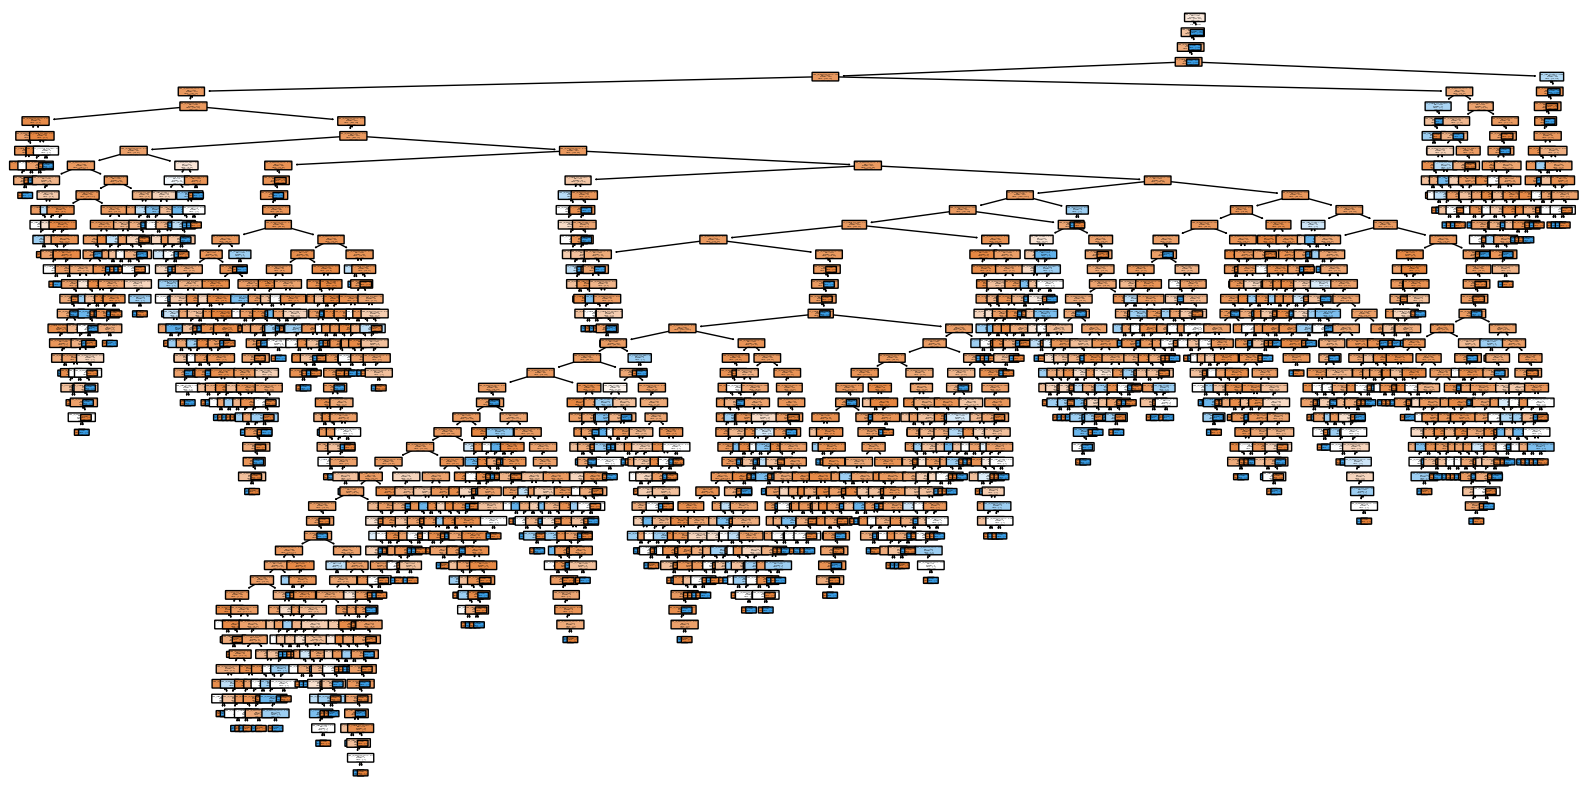

In [14]:
def visualize_tree(tree, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=feature_names, filled=True, rounded=True, class_names=True)
    plt.show()

# Visualize the default decision tree
default_tree_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', default_tree)
])
default_tree_pipeline.fit(X_train, y_train)
visualize_tree(default_tree_pipeline.named_steps['model'], preprocessor.get_feature_names_out())